# NLP Project Sectorlense Contract checker

**Projectdescription**

Reviewing software contracts is often a complex and error-prone task, particularly when
assessing standardized requirements and identifying potential risks. Manual contract review
can be time-consuming, leading to inconsistencies and oversight. To address this challenge,
the project aims to develop an LLM-based contract checker that automates the review
process. By leveraging predefined checklists and legal standards, the system will
systematically analyze contracts, ensuring that required clauses are present while also
detecting critical or unusual formulations. This will streamline contract evaluation and
facilitate structured risk assessment, reducing both time and effort for legal professionals
and businesses.

The contract checker will incorporate three primary functionalities. A standard compliance
check will verify whether contracts include the necessary clauses and if they adhere to
established legal and business standards. Assessment based on standardized criteria will
evaluate key contractual aspects to ensure completeness and compliance. Risk identificatalogue_rawion
will highlight non-standard, ambiguous, or high-risk clauses, enabling users to assess their
appropriateness compared to standard contract terms. Additionally, an optional risk
detection feature could be introduced to flag further potential risks that may not be explicitly
covered in the predefined checklist.

The final deliverable will be a web application that enables users to upload contract
documents and receive an automated structured review including insights on compliance
and risk factors. This application will provide detailed feedback, highlight critical sections,
and suggest improvements, making contract review more efficient and reliable.
Development will build upon an existing prototype that includes both a frontend and basic
functionality, allowing for enhancements in accuracy, usability, and scalability.

**Meilensteine**:

Milestone 1: Understanding existing prototype and defining key requirements (Week 1-2)

Milestone 2: Developing/improving NLP-based contract analysis model (Week 3-6)

Milestone 3: Integration into the web application (Week 7-8)

Milestone 4: Testing and evaluation with real-world contracts (Week 9-10)

Milestone 5: Final presentation and documentation (Week 11-12)

**Data**

Contract documents in various formats (PDF, DOCX, TXT). Predefined checklists and legal standards.

In [1]:
# ==============================================================================
#  SYSTEM & ENVIRONMENT
# ==============================================================================
import os
import sys
import ssl
import certifi
import random
import pickle
import time
from pathlib import Path
from dotenv import load_dotenv

# SSL-Config (NLTK, Requests)
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# ==============================================================================
#  DATA HANDLING
# ==============================================================================
import pandas as pd
import numpy as np

# ==============================================================================
#  TEXT PROCESSING & NLP
# ==============================================================================
import string
import re
from itertools import chain

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import en_core_web_sm

from gensim.parsing.preprocessing import (
    STOPWORDS,
    strip_tags,
    strip_numeric,
    strip_punctuation,
    strip_multiple_whitespaces,
    remove_stopwords,
    strip_short,
    stem_text
)

from sklearn.feature_extraction.text import CountVectorizer

# ==============================================================================
#  FILE READING & SCRAPING
# ==============================================================================
import pdfplumber
import docx
import requests
from bs4 import BeautifulSoup

# ==============================================================================
#  VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# ==============================================================================
#  MACHINE LEARNING / DEEP LEARNING
# ==============================================================================
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    roc_curve,
    auc
)
from sklearn.metrics.pairwise import cosine_similarity

# Transformers & Sentence Embeddings
from transformers import (
    BertTokenizer,
    BertModel,
    AutoTokenizer,
    AutoModel,
    AutoConfig
)

from sentence_transformers import SentenceTransformer, models
from sentence_transformers.models import Pooling

import inspect

# ==============================================================================
#  OPENAI API AND JSON HANDLING
# ==============================================================================
from openai import OpenAI
import json

# Import API key from parent directory
sys.path.append(os.path.abspath(".."))
from key import OpenAiKey

# ==============================================================================
#  REPRODUCIBILITY
# ==============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==============================================================================
#  CUSTOM FUNCTIONS AND CLASSES
# ==============================================================================
# File scraping and reading
from functions.function_contract_read_in import (  
    scrape_html_standard,
    scrape_html_commonpaper,
    scrape_html_fakturia,
    scrape_html_mitratech,
    scrape_contract_auto,
    read_txt_file
)

# Text preprocessing
from functions.functions_preprocessing import ( 
    extract_paragraphs_and_sections,
    extract_title_fixed,
    clean_sections_and_paragraphs
)

# Embeddings
from functions.functions_embeddings import add_embed_text_column

# Core aspect evaluation
from functions.functions_fullfillment_criteria import (
    check_core_aspects_with_llm,
    evaluate_fullfillment_on_criteria
)

# Model components
from classes.class_model import CosineMapper
from classes.Class_TextLabelDataset import TextLabelDataset
from classes.class_predictor import SectionTopicPredictor



[nltk_data] Downloading package stopwords to /Users/dave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Current working directory: /Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/notebooks


# 1. Read in Contracts

The contract checker tool that is going to be created in this project needs to be tested and trained based on some real world example contracts. Therefore Sectorelense provided us with an excel sheet containing a list of various providers of Saas solutions and links to their websites where sample contracts are available.

These contract documents appear in various formats. Some of them in HTML, some in PDF, some in DOCX and some in the format of JSON.

To automate the collection of contracts our first approach was to try to build an automated scraping tool for each file format.

## 1.1 Scraping HTML
We Started by creating a scraping tool for HTML websites. After a short time we realised that this woulden´t be as easy as expected, since all the websites appear in different formats which leads to different scraping properties for every website.

However we proceeded and tried to build a seperate scraping function for all the provided websites that seemed to be impactfull to us.

The following code shows scraping functions for different kind of websites. In the end you can find a chooser function, that chooses which scraping functtion to use exactly based on the link provided.

In [2]:

# # 1. Scraper für Standard-HTML-Verträge
# def scrape_html_standard(url):
#     try:
#         headers = {
#             "User-Agent": (
#                 "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
#                 "AppleWebKit/537.36 (KHTML, like Gecko) "
#                 "Chrome/122.0.0.0 Safari/537.36"
#             )
#         }
#         response = requests.get(url, headers=headers)
#         response.encoding = 'utf-8'
#         response.raise_for_status()

#         soup = BeautifulSoup(response.text, "html.parser")
#         for tag in soup(["script", "style", "header", "footer", "nav"]):
#             tag.decompose()

#         main_content = soup.find("div", class_="single-content") or soup
#         raw_text = main_content.get_text(separator=" ", strip=True)
#         full_text = re.sub(r'\s+', ' ', raw_text)

#         start_patterns = [r"§\s?\d+", r"1\.\s+[^\n\.]+"]
#         for pattern in start_patterns:
#             match = re.search(pattern, full_text)
#             if match:
#                 full_text = full_text[match.start():]
#                 break

#         end_markers = [
#             "Die eingetragene Marke MOCO", "Stand 12/2024", "Ort, Datum",
#             "Unterschrift", "Impressum", "©", "Nachtrag Australische spezifische Begriffe"
#         ]
#         cutoff = int(len(full_text) * 0.7)
#         positions = {m: full_text.find(m) for m in end_markers if full_text.find(m) > cutoff}
#         if positions:
#             full_text = full_text[:min(positions.values())]

#         return full_text.strip()

#     except Exception:
#         return ""


# # 2. Scraper für CommonPaper-Verträge
# def scrape_html_commonpaper(url):
#     try:
#         response = requests.get(url)
#         response.raise_for_status()

#         soup = BeautifulSoup(response.text, "html.parser")
#         content = soup.find("div", class_="entry-content")
#         if not content:
#             print(f"⚠️ CommonPaper: Kein Hauptbereich gefunden – {url}")
#             return ""

#         result = []

#         def walk_list(ol, prefix=""):
#             items = ol.find_all("li", recursive=False)
#             for idx, li in enumerate(items, 1):
#                 number = f"{prefix}.{idx}" if prefix else str(idx)
#                 li_copy = BeautifulSoup(str(li), "html.parser")
#                 for sublist in li_copy.find_all("ol"):
#                     sublist.decompose()
#                 text = li_copy.get_text(separator=" ", strip=True)
#                 result.append(f"{number}. {text}")

#                 sub_ol = li.find("ol")
#                 if sub_ol:
#                     walk_list(sub_ol, number)

#         top_ol = content.find("ol")
#         if top_ol:
#             walk_list(top_ol)
#         else:
#             print("⚠️ Keine <ol> gefunden!")

#         return "\n".join(result)

#     except Exception as e:
#         print(f"Fehler beim Scrapen CommonPaper: {e}")
#         return ""


# # 3. Scraper für Fakturia-Verträge
# def scrape_html_fakturia(url):
#     try:
#         headers = {
#             "User-Agent": (
#                 "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
#                 "AppleWebKit/537.36 (KHTML, like Gecko) "
#                 "Chrome/122.0.0.0 Safari/537.36"
#             )
#         }
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()

#         soup = BeautifulSoup(response.text, "html.parser")
#         content = soup.find("div", class_="entry-content-wrapper")
#         if not content:
#             print("⚠️ Fakturia: Kein Hauptbereich gefunden.")
#             return ""

#         result = []
#         section = ""

#         for elem in content.find_all(["h2", "p"]):
#             text = re.sub(r'\s+', ' ', elem.get_text(separator=" ", strip=True))

#             if elem.name == "h2":
#                 if section:
#                     result.append(section.strip())
#                 section = text + "\n"
#             elif elem.name == "p":
#                 if re.match(r'^\d+\.\d+', text):
#                     section += text + " "
#                 else:
#                     section += text + "\n"

#         if section:
#             result.append(section.strip())

#         for marker in ["Copyright OSB Alliance e.V.", "gemäß CC BY", "Version 1/2015"]:
#             if marker in result[-1]:
#                 result[-1] = result[-1].split(marker)[0].strip()
#                 break

#         return "\n\n".join(result)

#     except Exception as e:
#         print(f"Fehler beim Scrapen Fakturia: {e}")
#         return ""


# # 4. Scraper für Mitratech-Verträge
# def scrape_html_mitratech(url):
#     try:
#         headers = {
#             "User-Agent": (
#                 "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
#                 "AppleWebKit/537.36 (KHTML, like Gecko) "
#                 "Chrome/122.0.0.0 Safari/537.36"
#             )
#         }
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()

#         soup = BeautifulSoup(response.text, "html.parser")
#         for tag in soup(["script", "style", "header", "footer", "nav", "form", "noscript"]):
#             tag.decompose()

#         main = soup.find("main") or soup
#         found = False
#         blocks = []

#         for el in main.find_all(["h1", "h2", "h3", "p", "li", "ol", "ul"]):
#             text = el.get_text(separator=" ", strip=True)
#             if not text:
#                 continue

#             if not found and text.startswith("1. Allgemeines"):
#                 found = True
#                 blocks.append(text)
#                 continue

#             if found and el.name in ["h1", "h2", "h3"] and "Begriffsbestimmungen" in text:
#                 break

#             if found:
#                 blocks.append(text)

#         return "\n\n".join(blocks).strip()

#     except Exception as e:
#         print(f"Fehler beim Scrapen Mitratech: {e}")
#         return ""


# # Automatische Auswahl je nach URL
# def scrape_contract_auto(url):
    # url_lc = url.lower()
    # if "commonpaper.com" in url_lc:
    #     return scrape_html_commonpaper(url)
    # elif "fakturia.de" in url_lc:
    #     return scrape_html_fakturia(url)
    # elif "mitratech.com" in url_lc or "alyne.com" in url_lc:
    #     return scrape_html_mitratech(url)
    # else:
    #     return scrape_html_standard(url)

## 1.2 Reading in PDF, DOCX and JSON

Since we realised that all the files are delivered in different formats and therefore trying to automate the reading process won´t be really sucsesfull, since you have to write a new function for every document we stopped that approach. If we would continue like this we would have to write a seperate function for each document, considering the slight differences each document comes with.

Since this would consume a lot of time and is not very efficient as prooven by the HTML example we decided to simply copy all the relevant DOCX, PDF and JSON files into TXT files manually. This is because it is way easier for us to read in txt files that are all in the same format.

This project is about NLP and not so much about building automated scraping tools. Therefore we think this apporach is reasonable.

**TXT**

In [3]:
# #Funktion zum einlesen von .txt files
# def read_txt_file(file_path):
#     try:
#         with open(file_path, "r", encoding="utf-8") as file:
#             content = file.read()
#         return content
#     except Exception as e:
#         print(f"Fehler beim Einlesen der Datei: {e}")
#         return ""

**Read mapping**

In [4]:
list_of_contract_meta = pd.read_excel(Path("../data/input_mapping/Mappingliste_Verträge.xlsx")) 

**Neue Spalte Content und Filetype in DF erzeugen**

In [5]:
df =list_of_contract_meta # check out list of contracts to 'df'

if 'Content' not in df.columns:
    df['Content'] = ""

if 'FileType' not in df.columns:
    df['FileType'] = ""

**TxT files und HTML links automatisiert in Data Frame einlesen und als pickle file speichern**

In [6]:
# Basisordner für lokale Vertragsdateien


path_txt_contracts = Path("../data/verträge/verträge_txt")


# Iteration über die Mapping-Tabelle
for idx, row in df.iterrows():
    mapping_field = row['Mapping']
    content = ""
    file_type = ""

    if pd.notna(mapping_field):
        mappings = [m.strip() for m in mapping_field.split(';')]
        texts = []

        for i, mapping in enumerate(mappings):
            if mapping.endswith('.txt'):
                filename = Path(mapping).name  # nur Dateiname
                filepath = path_txt_contracts  / filename
                texts.append(read_txt_file(filepath))
                if i == 0:
                    file_type = "TXT"
            else:
                continue
                # texts.append(scrape_contract_auto(mapping))
                # if i == 0:
                #     file_type = "HTML"

        content = "\n\n".join(texts)

    df.at[idx, 'Content'] = content
    df.at[idx, 'FileType'] = file_type

list_of_contracts = df.copy()
del df, list_of_contract_meta, path_txt_contracts


**Englische Texte übersetzen**

In [7]:
df = list_of_contracts.copy() # check out list of contracts to 'df'
# # .env laden für API-Key
# load_dotenv()

# # src-Ordner zum Pfad hinzufügen, damit translate.py importiert werden kann
# sys.path.append(str(Path("..") / "src"))

# # Funktion importieren
# from translate import translate_dataframe
# # Übersetzung auf Texte mit Sprache 'EN' anwenden
# df = translate_dataframe(df)
list_of_contratcts_translated = df.copy() # check out list of contracts to 'df'
del df, list_of_contracts
print(list_of_contratcts_translated)


                                            Kategorie  Quelle/Organisation  \
0                                Verbände / Templates    IT-Recht Hannover   
1                                Verbände / Templates      3H Solutions AG   
2                                Verbände / Templates         Common Paper   
3   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
4   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
5   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
6   Öffentlich zugängliche Verträge großer SaaS-An...               Oracle   
7   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
8   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
9                kleinere SaaS-Anbieter (Hauptgruppe)             Fakturia   
10               kleinere SaaS-Anbieter (Hauptgruppe)               Dräger   
11               kleinere SaaS-Anbieter (Hauptgruppe)           

**Fertige input files als pickle file speichern**

In [8]:
# Ausgabeordner und -datei
#output_pickle_path = Path("../data/data_scraped_input.pkl")
# Ergebnisse speichern
#list_of_contratcts_translated.to_pickle(output_pickle_path)
# Nur "nicht eingebaute" Variablen anzeigen
del list_of_contratcts_translated #,  output_pickle_path


# 2. Data cleaning
## 2.1 Data Loading and Initial Structuring

In the first step, we load the data from the pickled dataset produced by the data_script_input. After reading in the contracts, each entry in our custom dataset is enriched with key metadata, including:

- the source of the data
- the document type
- a mapping to the original source website
- the language of the document
- the full contract content
- and the file type

This step ensures that all contracts are consistently structured and traceable back to their origin.

In [9]:
all_contracts_content = pd.read_pickle("../data/data_scraped_input.pkl")
display(all_contracts_content.head())
df = all_contracts_content

,Kategorie,Quelle/Organisation,Dokumententyp,Mapping,Sprache,Content,FileType
0,Verbände / Templates,IT-Recht Hannover,Muster SaaS-Vertrag,https://it-rechthannover.de/IT-Muster/SaaS-Ver...,DE,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...,HTML
1,Verbände / Templates,3H Solutions AG,Standard-Vertragsbedingungen SaaS,Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...,DE,Standard-Vertragsbedingungen\nSaaS- und Clouds...,TXT
2,Verbände / Templates,Common Paper,Cloud Service Agreement,https://commonpaper.com/standards/cloud-servic...,EN,1. Service\n1.1. Access and Use. During the Su...,HTML
3,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,SaaS_SAP_Service_Level_Agreement.txt,DE,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...,TXT
4,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,Saas_SAP_General_Terms.txt,DE,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...,TXT


**Example of Contract Content:**

In [10]:

print(df.iloc[13, 5][:1000] + "...")

Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

## 2.2 Filter and Select Data 
For further data processing, we retain only the content and contract columns, as these contain the essential information for our analysis.

Additionally, we focus exclusively on contracts written in German, since the goal is to develop a German-language contract checker. Filtering by language at this stage ensures consistency and avoids noise from multilingual data.

In [11]:
# filter df to relevant contracts
df = df[#(df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") & 
                    (df['Sprache'] == "DE") #& (df['Quelle/Organisation'] != "Comarch ERP XT"	)
                    ]
df = df.iloc[:,[5]]
df.columns = ['content']
df["contract"] = range(1, df.shape[0] + 1)
df = df[['contract', 'content']]


**Example:**

In [12]:

contract_contents_german_only = df.copy()
print(contract_contents_german_only .head())


with open("../data/contract_contents_german_only", "wb") as f:
    pickle.dump(contract_contents_german_only, f)

# Save the DataFrame to an Excel file
contract_contents_german_only.to_excel("../data/contract_contents_german_only.xlsx", index=False)

del df, all_contracts_content

   contract                                            content
0         1  § 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1         2  Standard-Vertragsbedingungen\nSaaS- und Clouds...
3         3  SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4         4  ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5         5  SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


## 2.3 Slicing 
Since we aim to analyze individual sections rather than entire contracts, the next step is to split the contract texts into smaller segments. Specifically, we divide each contract into multiple rows, first by paragraphs, and then by subsections within each paragraph. This segmentation makes it possible to process and classify specific parts of the contract more effectively.

In [13]:
# def extract_paragraphs_and_sections(row, col='content', contract_col='contract', print_steps = False):
#     import re

#     text = row[col]
#     if contract_col ==None:
#         contract_id= 1
#     else:
#         contract_id = row['contract']
#     lines = text.splitlines()
#     paragraphs = []
#     current_para_lines = []
#     current_para_number = 0
#     current_para_match = None
#     match_pat_type_1 = True
#     match_pat_type_2 = True
#     match_pat_type_3 = True
#     para_mode = None

#     # 1. extract paragraphs

#     for line in lines:
#         line = line.strip()
#         if not line:
#             continue

#         search_for = str(int(current_para_number) + 1)

        
#         if para_mode == "symbol":
#             if search_for:
#                 match_main = re.match(rf'§\s*{search_for}(?!\d)', line)
#         elif para_mode == "number":
#             if search_for:
#                 match_main = re.match(rf'\b{search_for}\.(?!\d)', line)
#         else:
#             # Noch kein Modus festgelegt: beides probieren
#             match_main = re.match(rf'(§\s*(\d+))(?!\d)|\b(\d+)\.(?!\d)', line)
#             if match_main:
#                 if match_main.group(1):  # § X
#                     para_mode = "symbol"
#                 elif match_main.group(3):  # X.
#                     para_mode = "number"
       

#         if match_main:
#             if current_para_lines:
#                 paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))
#             current_para_number = match_main.group(0).strip().lstrip('§').rstrip('.').strip()  # e.g § 2 lorem ipsum --> 2
#             current_para_lines = [line]                                                        # e.g § 2 lorem ipsum --> § 2 lorem impsum
#             current_para_match = match_main.group(0).strip()                                   # e.g § 2 lorem ipsum --> § 2
#         elif current_para_lines:
#             current_para_lines.append(line)

#     if current_para_lines:
#         paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))

#     rows = []
#     seen_sections = set()  # (contract_id, para_num, section_id)

#     for para_num, para_text, para_match in paragraphs:
        
#         if para_mode == "number":
#             matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)', para_text))
#         if para_mode == "symbol":
#             matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)|\b(\d+)\.(?!\d)', para_text))

#         if print_steps:
#             print(para_num)
#             print(seen_sections)
#             print(para_text)
#             print(matches)
            

#         if not matches:
#             rows.append({
#                 'contract': contract_id,
#                 'paragraph': para_match,
#                 'paragraph_content': para_text.strip(),
#                 'section': "no sections use paragraph",
#                 'section_content': para_text.strip()
#             })
#             continue

#         positions = []
#         last_section_number = 0
        

#         for match in matches:
#             # hole entweder dezimale section (z. B. 1.1) oder Klammer-section (z. B. (1))
#             section_id = match.group(1) or match.group(2) or match.group(3)
#             start = match.start()

#             # Unterscheide die Formate
#             if match.group(1) and match_pat_type_1:  # Dezimal: z. B. "1.5"
#                 try:
#                     section_suffix = int(section_id.split(".")[1])
#                 except (IndexError, ValueError):
#                     continue  # überspringen bei Fehler
#                 match_pat_type_2 = False # If first pattern type detected only look for this one
#                 match_pat_type_3 = False

#                 # verbiete z. B. "1.50"
#                # if re.match(rf'{para_num}\.\d{{2,}}$', section_id):
#                 #    continue

#             elif match.group(2) and match_pat_type_2:  # Klammer: z. B. "(2)"
#                 try:
#                     section_suffix = int(section_id.strip("()")) 
#                     section_id = f'({section_suffix})'  # Einheitliches Format für Ausgabe
#                 except ValueError:
#                     continue
#                 match_pat_type_1 = False # If second pattern type detected only look for this one
#                 match_pat_type_3 = False
#             elif para_mode == "symbol" and match.group(3) and match_pat_type_3:  # 1. (nur bei mode=symbol)
#                 if print_steps:
#                     print(section_id)
#                 try:
#                     section_suffix = int(section_id.split(".")[0])
#                     section_id = f'{section_suffix}.'  # für Klarheit
#                 except ValueError:
#                     continue
#                 match_pat_type_1 = False # If third pattern type detected only look for this one
#                 match_pat_type_2 = False

#             else:
#                 continue  # kein gültiges Format

#             # Nur nächste Zahl zulassen
#             if last_section_number != 0 and section_suffix != last_section_number + 1:
#                 continue

#             section_key = (contract_id, para_num, section_id)
#             if section_key in seen_sections:
#                 continue

#             seen_sections.add(section_key)
#             positions.append((start, section_id))
#             last_section_number = section_suffix


#         # Add end position
#         positions.append((len(para_text), None))
#         positions = sorted(positions)
#         if print_steps:
#             print(f'positions = {positions}')
#             print('###########')

#         for i in range(len(positions) - 1):
#             start_pos = positions[i][0]
#             end_pos = positions[i + 1][0]
#             section_id = positions[i][1]
#             section_text = para_text[start_pos:end_pos].strip()

#             rows.append({
#                 'contract': contract_id,
#                 'paragraph': para_match,
#                 'paragraph_content': para_text.strip(),
#                 'section': section_id,
#                 'section_content': section_text
#             })

#     return rows


**New structure**:

In [14]:
df = contract_contents_german_only.copy() # check out list of gernman contracts to 'df'

sections = df.apply(extract_paragraphs_and_sections, axis=1)
print(sections.head())
rows = list(chain.from_iterable(sections))
df = pd.DataFrame(rows)
print("               \\#########/")
print("                \\#######/")
print("                 \\#####/")
print("                  \\###/")
print("                   \\#/")
contract_sections = df.copy()
del df, sections, rows


display(contract_sections[["contract","paragraph","section"]])

0    [{'contract': 1, 'paragraph': '§ 1', 'paragrap...
1    [{'contract': 2, 'paragraph': '§ 1', 'paragrap...
3    [{'contract': 3, 'paragraph': '1.', 'paragraph...
4    [{'contract': 4, 'paragraph': '1.', 'paragraph...
5    [{'contract': 5, 'paragraph': '1.', 'paragraph...
dtype: object
               \#########/
                \#######/
                 \#####/
                  \###/
                   \#/


,contract,paragraph,section
0,1,§ 1,1.1
1,1,§ 1,1.2
2,1,§ 1,1.3
3,2,§ 1,(1)
4,2,§ 1,(2)
...,...,...,...
1371,26,19.,19.2
1372,26,19.,19.3
1373,26,19.,19.4
1374,26,19.,19.5


In a second step, we aim to extract paragraph titles directly from the paragraph content. To achieve this, we use regular expressions (regex) that match common patterns typically found at the beginning of legal paragraphs—such as numbered clauses, keywords like "Der", "Ein", or "Eine", or capitalized phrases.

Since this is not working totally well and quite often ni recognizable pattern is found, we apply a fallback strategy: we extract a short snippet from the beginning of the paragraph (e.g., the first few words or until the first full sentence) to serve as a temporary title.

This ensures that each paragraph receives a consistent and descriptive title, even if the document does not explicitly define one. These titles are useful for labeling, classification, and structuring contract documents for downstream tasks. Furthermore the Paragraph tag and the number is removed. 

Since we want the later algorithm to focus on the content rather than focusing on the title we also remove the title from the content of the prargraph as well as drom the content of the section

In [15]:
# def extract_title_fixed(group):
#     import re
#     paragraph_text = group['paragraph_content'].iloc[0]
#     section_texts = group['section_content'].tolist()

#     # No Sections (single paragraph)
#     if len(section_texts) == 1 and group['section'].iloc[0] == "no sections use paragraph":
#         # find sentence end
#         match = re.search(r'\b(Der|Die|Das|Es|Ein|Eine)\s+[A-ZÄÖÜ][a-zäöü]+\b', paragraph_text)
#         if match:
#             title = paragraph_text[:match.start()].strip()
#         else:
#             # Fallback: to first verb or 8 words
#             title = ' '.join(paragraph_text.split()[:8])
#         return pd.Series([title] * len(group), index=group.index)

#     # secction split
#     for section in section_texts:
#         paragraph_text = paragraph_text.replace(section, '')
#     title = paragraph_text.strip()
#     return pd.Series([title] * len(group), index=group.index)

In [16]:
df = contract_sections.copy() # check out sliced contracts to df
df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


df = df[
    ['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']
]


df['paragraph_title'] = df.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)


df["paragraph_content"] = df.apply(
    lambda row: row["paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["paragraph_content"]) else '',
    axis=1
)

df["section_content"] = df.apply(
    lambda row: row["section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["section_content"]) else '',
    axis=1
)

contract_sections_raw = df.copy() 
del df, contract_sections


/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_18814/2945032267.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


**New structure**:

In [17]:
display(contract_sections_raw.head())
output_pickle_path = Path("../data/contract_sections_raw.pkl")
# Ergebnisse speichern
contract_sections_raw.to_pickle(output_pickle_path)
contract_sections_raw.to_excel("../data/df_contract_sections_raw.xlsx", index=False)
del contract_sections_raw, output_pickle_path

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


## 2.3 Cleaning

In the next step, we focused on cleaning and normalizing the core of the dataset. For this purpose, we implemented a flexible function that allows us to experiment with various cleaning strategies via parameters. These options include:

- Removing all paragraph markers (e.g., “§”, “1.2”)
- Converting all text to lowercase
- Stripping HTML tags
- Removing numbers
- Removing punctuation
- Reducing multiple whitespaces to a single space
- Removing short words (e.g., ≤ 2 characters)
- Removing known stopwords (using Gensim’s stopword library)
- Applying stemming to reduce words to their root form

We tested various combinations of these settings across multiple runs. The best results were achieved with all cleaning steps enabled, except for stemming, which tended to distort meaning too much in our context.

Therefore, we adopted this configuration as our standard cleaning approach going forward.



In [18]:
contract_sections_raw = pd.read_pickle("../data/contract_sections_raw.pkl")
display(contract_sections_raw.head())
df = contract_sections_raw.copy()

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


In [19]:
# def clean_sections_and_paragraphs(
#     text,
#     remove_paragraph_markers=True,
#     to_lower=True,
#     remove_tags=True,
#     remove_numbers=True,
#     remove_punctuation=True,
#     remove_extra_whitespace=True,
#     strip_short_words=False,
#     remove_stopwords =False,
#     apply_stemming=False
# ):
#     if not isinstance(text, str):
#         return ""

#     if to_lower:
#         text = text.lower()

#     if remove_paragraph_markers:
#         # Remove paragraph indicators like "§ 1", "1.", "1.1" etc.
#         text = re.sub(r'^(§?\s*\d+[a-zA-Z]*[.)]?(\s*\(?\d+[.)]?)?)', '', text)
#         text = re.sub(r'\(?\b\d{1,2}(\.\d{1,2})?\)?', '', text)

#     if remove_tags:
#         text = strip_tags(text)

#     if remove_numbers:
#         text = strip_numeric(text)

#     if remove_punctuation:
#         text = strip_punctuation(text)

#     if remove_extra_whitespace:
#         text = strip_multiple_whitespaces(text)

#     if strip_short_words:
#         text = strip_short(text, minsize=3)

#     if remove_stopwords:
#         text = remove_stopwords(text, stopwords=STOPWORDS) # !!!!!! Englische Stopwörter  !!!!!!!

#     if apply_stemming:
#         text = stem_text(text)

#     return text.strip()


**appling the function with deaults**:

In [20]:
df["clean_paragraph_content"] = df["paragraph_content"].apply(clean_sections_and_paragraphs)
df["clean_section_content"] = df["section_content"].apply(clean_sections_and_paragraphs)
contract_sections_clean = df.copy()
del df, contract_sections_raw


Example clean paragraph:

In [21]:
print(contract_sections_clean["clean_paragraph_content"][0][:150] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infrastruktur zugänglich ist die nutzung umfasst die b...


Example clean section:

In [22]:

print(contract_sections_clean["clean_section_content"][0][:100] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infr...


# 2.4 Visualizing Token Distributions with Word Clouds
To gain a better understanding of the most common words and tokens used across the contracts—at the session and paragraph level—we plan to generate several word clouds.

These visualizations will be based on different tokenization stages, including:

- Raw tokenization (including punctuation and original casing),
- Stemming, and
- Lemmatization

By comparing these different views, we aim to identify frequently used legal terms, recurring patterns, and potentially meaningful vocabulary that could inform our downstream tasks such as classification, clustering, or contract clause extraction.

In [23]:
%matplotlib inline
nlp = en_core_web_sm.load()
bert_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlparaphrase_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
df = contract_sections_clean.copy()

### paragraphs
df["paragraph_content_stemm"]=df['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)
df["paragraph_content_lemma"]=df['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df["paragraph_content_token_bert"]=df['clean_paragraph_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

df["paragraph_content_token_mlp"]=df['clean_paragraph_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

### sections

df["section_content_stemm"]=df['clean_section_content'].apply(
    lambda text: stem_text(text)
)
df["paragraph_section_lemma"]=df['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df["paragraph_section_token_bert"]=df['clean_section_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

df["paragraph_section_token_mlp"]=df['clean_section_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

columns_and_titles = [
    ("paragraph_content_stemm", "Paragraph – Stemmed"),
    ("paragraph_content_lemma", "Paragraph – Lemmatized"),
    ("paragraph_content_token_bert", "Paragraph – BERT Tokens"),
    ("paragraph_content_token_mlp", "Paragraph – Mulitlingual Paraphrase Tokens"),
    ("section_content_stemm", "Section – Stemmed"),
    ("paragraph_section_lemma", "Section – Lemmatized"),
    ("paragraph_section_token_bert", "Section – BERT Tokens"),
    ("paragraph_section_token_mlp", "Section – Mulitlingual Paraphrase Tokens"),
]


tab_contents = []

for col, title in columns_and_titles:
    output = widgets.Output()
    with output:
        # Join tokens for token-based columns, else join raw text
        if "token" in col:
            all_text = " ".join([" ".join(tokens) if isinstance(tokens, list) else str(tokens)
                                for tokens in df[col].dropna()])
        else:
            all_text = " ".join(df[col].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Wordcloud – {title}", fontsize=16)
        plt.show()
        plt.close() 

        tab_contents.append((title, output))

# Tabs erzeugen

tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)





Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors


===> Save cleaned Contract content

In [24]:
file_path = '../data/contract_sections_clean.pkl'
contract_sections_clean.to_pickle(file_path)
contract_sections_clean.to_excel("../data/data_clean.xlsx", index=False)

# 3. Labeling
## 3.1 Catalog cleaning
In the next step, our goal is to assign labels to as many of our contract sections as possible, based on a predefined requirement catalog.
The requirement catalog consists of the following three components:

- Paragraph Topic: This indicates which paragraph or general area of the contract the requirement refers to.
- Section Topic: A short guiding question that describes the specific aspect or issue that should be addressed within that section of the contract.
- Example Sentence: A concrete example taken from an actual SaaS contract that illustrates how this requirement might typically be formulated in legal language.

This structured setup allows us to later match contract content to catalog entries based on thematic and semantic similarity.

However, before we can map the requirement catalog to our contract data, we first need to clean the example phrases (reference texts) contained within the catalog itself. These examples need to go through the same preprocessing pipeline, such as lowercasing, punctuation removal, and stopword filtering, to ensure that the label mapping is accurate and consistent with the processed contract content.

Only once both the contract data and the catalog examples are cleaned can we begin matching them effectively for label assignment.

**<=== load the raw catalogue**

In [25]:
catalogue_raw = pd.read_excel("../data/catalogue_raw.xlsx")
display(catalogue_raw)
df = catalogue_raw.copy()


,paragraph_topic,section_topic,example
0,Projektkosten & Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,„Im Festpreis von 200.000 € sind sämtliche Lei...
1,Projektkosten & Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,„Der Kunde zahlt eine monatliche Pauschale von...
2,Projektkosten & Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,„Die Vergütung ist in drei Raten zahlbar: 30% ...
3,Projektkosten & Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",„Alle Preise verstehen sich in Euro zuzüglich ...
4,Projektkosten & Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,„Reise- und Übernachtungskosten werden nur ers...
...,...,...,...
71,Sonstige wichtige Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,„Dieser Vertrag unterliegt dem Recht der Bunde...
72,Sonstige wichtige Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,„Gerichtsstand für alle Streitigkeiten aus ode...
73,Sonstige wichtige Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",„Dieser Vertrag wird in deutscher und englisch...
74,Sonstige wichtige Klauseln,Enthält der Vertrag eine salvatorische Klausel...,„Sollte eine Bestimmung dieses Vertrages unwir...


In [26]:

df["example"] = df["example"].str.strip('„“"').apply(clean_sections_and_paragraphs)
df["paragraph_topic"] = df["paragraph_topic"].apply(
    lambda x: x.replace("&", 'und').strip().replace(" ","_")
)

catalogue_clean= df.copy()

display(catalogue_clean.head())

file_path = '../data/catalogue_clean.pkl'  
catalogue_clean.to_pickle(file_path)
catalogue_clean.to_excel("../data/catalogue_clean.xlsx", index=False)

del df, catalogue_clean, catalogue_raw

,paragraph_topic,section_topic,example
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...


## 3.2 Embedings 
### Reusable Embedding Function for Multiple Models
Since we plan to experiment with various models throughout the project, and each model generates different embeddings, we created a reusable function that adds a new column to a given dataset. This column contains the embeddings computed by the specified model, based on a target text column. This setup allows us to easily switch between models and store their outputs for further analysis or comparison.

In [27]:
# def add_embed_text_column(df, text_column, model, target_column, batch_size=16):
#     """
#     Computes SentenceTransformer embeddings column-wise in batches, optimized for CPU performance.
#     """
#     texts = df[text_column].fillna("").tolist()
#     all_embeddings = []

#     for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
#         batch = texts[i:i+batch_size]
#         with torch.no_grad():
#             emb = model.encode(batch, convert_to_tensor=True)
#         all_embeddings.extend(emb.cpu().numpy())

#     df[target_column] = all_embeddings
#     return df

## 3.3 Initial Labeling via Embedding Similarity (Deprecated Due to Data Leakage)
Our initial approach was to label the dataset using cosine similarity between contract embeddings and requirement catalog examples, based on a selected model and only doublecheked by a human. The idea was to use these labels later to evaluate and compare different classification models.

However, as the project progressed, we realized that this method introduced data leakage, since the same embeddings used for labeling were also used during model evaluation. To avoid biased results, we decided to abandon this approach in favor of a more robust labeling strategy.

Nevertheless, for the sake of completeness, the original method is documented below.

**<=== load data_clean**


In [28]:
contract_sections_clean_unlabeled = pd.read_pickle('../data/contract_sections_clean.pkl')
df = contract_sections_clean_unlabeled
catalogue_clean = pd.read_pickle('../data/catalogue_clean.pkl'  )

# Set seed and sample data
random.seed(2211)
sample_indices = random.sample(range(len(df["clean_section_content"])), k=600) # Zeiel 600 gelabelte Sections

# Choose the model to evaluate
model_url = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_name = "multilingual_paraphrase_sentence"

# Copy and sample data
df = df.iloc[sample_indices, :].copy()

model_word_embd = models.Transformer(model_url, max_seq_length=512)

pooling_model = models.Pooling(
            model_word_embd.get_word_embedding_dimension(),
            pooling_mode_cls_token=False,           
            pooling_mode_mean_tokens=True,         # ✅ Mean laut chat gpt besser für semantische übereinstimmung
            pooling_mode_max_tokens=False,
        )

model = SentenceTransformer(modules=[model_word_embd, pooling_model])

# Embed contract sections
df = add_embed_text_column(
    df,
    text_column="clean_section_content",
    model= model,
    target_column="section_embeddings"
)

# Embed catalog examples
catalogue = add_embed_text_column(
    catalogue_clean,
    text_column="example",
    model=model,
    target_column="example_ebeddings"
)

# Keep only relevant columns
df = df[["contract", "paragraph", "section", "clean_section_content", "section_embeddings"]]

# Compute cosine similarity
X = np.vstack(df["section_embeddings"].values)
Y = np.vstack(catalogue["example_ebeddings"].values)

similarity_matrix = cosine_similarity(X, Y)
similarity_percent = np.round(similarity_matrix * 100, 2)

# Best matches per section
best_match_idx = similarity_matrix.argmax(axis=1)
best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

# Store results
df[f"matched_example_index"]    = best_match_idx
df[f"similarity_percent"]       = best_match_score
df[f"matched_example_text"]     = catalogue.loc[best_match_idx, "example"].values
df[f"matched_example_topic"]    = catalogue.loc[best_match_idx, "section_topic"].values
df[f"matched_paragraph"]        = catalogue.loc[best_match_idx, "paragraph_topic"].values

# Summary stats
print(f"# {model_name}")
print("    mean similarity:",   df["similarity_percent"].mean())
print("    max similarity:",    df["similarity_percent"].max())
print("    min similarity:",    df["similarity_percent"].min())

# Example: best and worst match
df = df.sort_values(f"similarity_percent", ascending=False)
best_match = df.iloc[0]
print("\nBest match:")
print(f'{best_match["clean_section_content"]} \n### to ### \n{best_match["matched_example_text"]} \n### with score ### {best_match["similarity_percent"]}')

df = df.sort_values(f"similarity_percent", ascending=True)
worst_match = df.iloc[0]
print("\nWorst match:")
print(f'{worst_match["clean_section_content"]} \n### to ### \n{worst_match["matched_example_text"]} \n### with score ### {worst_match["similarity_percent"]}')

contract_sections_clean_labeled_600 = df.copy()
del df, catalogue_clean, contract_sections_clean_unlabeled

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

# multilingual_paraphrase_sentence
    mean similarity: 66.95322
    max similarity: 95.97
    min similarity: 22.23

Best match:
sollten einzelne bestimmungen dieses vertrags ganz oder teilweise unwirksam sein oder werden wird die wirksamkeit der übrigen bestimmungen hierdurch nicht berührt die parteien verpflichten sich für diesen fall die ungültige bestimmung durch eine wirksame bestimmung zu ersetzen die dem wirtschaftlichen zweck der ungültigen bestimmung möglichst nahekommt entsprechendes gilt für etwaige lücken dieser bedingungen 
### to ### 
sollte eine bestimmung dieses vertrages unwirksam oder undurchführbar sein oder werden bleibt die wirksamkeit der übrigen bestimmungen hiervon unberührt die parteien werden die unwirksame bestimmung einvernehmlich durch eine solche regelung ersetzen die dem wirtschaftlichen zweck der unwirksamen bestimmung am nächsten kommt 
### with score ### 95.97000122070312

Worst match:
allgemeinen geschäftsbedingungen für die comarch service produkte 

This results in a dataset containing the best matches between contract sections and catalog examples for mulitlingual paraphrase models.

In [29]:
display(contract_sections_clean_labeled_600 .sort_values(f"similarity_percent", ascending=False).head(5))
del contract_sections_clean_labeled_600 # Sackgasse

,contract,paragraph,section,clean_section_content,section_embeddings,matched_example_index,similarity_percent,matched_example_text,matched_example_topic,matched_paragraph
305,8,15.,15.5,sollten einzelne bestimmungen dieses vertrags ...,"[-0.0041314946, 0.096693866, -0.13690825, -0.0...",74,95.970001,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
683,16,14.,14.2,der vertrag untersteht dem recht der bundesrep...,"[-0.09444846, 0.19770819, -0.38321418, -0.1446...",71,93.180000,dieser vertrag unterliegt dem recht der bundes...,Ist die anwendbare Rechtsordnung eindeutig ver...,Sonstige_wichtige_Klauseln
142,6,4.,4.1,aufgrund dieses vertrags dürfen die parteien s...,"[-0.05984672, 0.04162008, -0.55982614, -0.0669...",35,93.180000,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit
1219,24,§ 19,19.3,sollten teile dieses vertrages ganz oder teilw...,"[-0.076217115, 0.06346369, -0.16947885, 0.0086...",74,92.820000,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
286,8,11.,11.1,die parteien verpflichten sich alle vertraulic...,"[-0.052296683, 0.086999364, -0.53502244, -0.11...",35,92.269997,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit


## 3.4 Manual mapping

However, as previously mentioned, the automatic labeling approach introduced data leakage. Therefore, we changed our strategy and switched to manual labeling of as many data points as possible.

Since this process is extremely time-consuming, and we are not legal experts — even in our native language, German — we were only able to manually label a total of 64 data samples.

Another challenge we encountered was that, although we had compiled a dataset of over 1,300 contract sections, we were unable to find suitable matches for all examples in the requirements catalog. As a result, 12 out of the 76 requirement items remain without any corresponding training data.

In essence, we manually reviewed all available contracts and initially searched for relevant keywords to identify potential matches. Once potential sections were found, we compared them directly to the example sections in the requirement catalog.

Only when we were 100% confident that a contract section semantically matched a catalog entry did we assign the corresponding catalog ID (i.e., the position of the example section within the catalog) to that contract section.

The following table shows a selection of sections from our dataset that have been mapped to their corresponding catalog_id (i.e., the index of the requirements catalog).

In [30]:
# df_unlabeled = pd.read_pickle("../data/contract_sections_clean.pkl")
# df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
# display(df_unlabeled)


# mapping = pd.read_excel("../data/mapping_human.xlsx")
# print(mapping.head())
# mapping = mapping[["contract","paragraph", "section","catalog_id"]]
# display(mapping)

# # Merge on both 'paragraph' and 'section' for more precise matching
# df_labeled = mapping.merge(df_unlabeled, how="left", on=["contract","paragraph", "section"])
# df_labeled= df_labeled[["contract","paragraph","section","section_content","clean_section_content","catalog_id"]]

# df_labeled.to_excel("../data/sections_labeled_manually.xlsx")
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))


,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


In [31]:
catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue_clean.head(5))

,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


# 4. Model Comparrison & Evaluation
We now move on to selecting the most suitable model. In total, we chose five different models from Hugging Face, all of which are Sentence Transformers, each with a corresponding tokenizer:

- "deepset/gbert-base"
- "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
- "bert-base-uncased",
- "jinaai/jina-embeddings-v2-small-en",
- "jinaai/jina-embeddings-v2-base-de",


Additionally, we need to decide on a pooling strategy. This strategy determines how we aggregate token-level embeddings into a single section-level embedding, which is essential for comparing sections rather than individual words.
When generating embeddings for full sections using transformer-based models, we must reduce the token-level output to a single fixed-size vector. This process is called pooling. Two common strategies are:

**CLS Token Pooling**
Uses the embedding of the special [CLS] token, which is prepended to every input by models like BERT.
The [CLS] token is explicitly trained (during pretraining) to capture the meaning of the entire sentence for classification tasks.
Advantage: In models trained for classification (e.g. BERT), the CLS token often encodes global sentence-level semantics efficiently.

**Mean Pooling**
Averages the embeddings of all tokens (excluding padding).
Provides a more balanced representation of the entire sentence or section.
Advantage: Especially useful in models not fine-tuned with CLS-specific objectives (e.g. multilingual or paraphrase models), where the semantic information is more evenly distributed across all tokens.

**Max Pooling**
Takes the maximum value across all token embeddings for each embedding dimension (excluding padding).
This emphasizes the most salient features that appear anywhere in the input, regardless of position.

Advantage: Max pooling can highlight strong semantic signals (e.g. key terms) by preserving their peak activations. This may be beneficial in tasks where individual high-impact words (rather than holistic meaning) are important — especially in longer or noisy texts.



## 4.1 Tokenizers and Embeddings

In [32]:
from transformers import logging
logging.set_verbosity_error()
model_names = [
    "gbert-base",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jina-embeddings-v2-small-en",
    "jina-embeddings-v2-base-de"
]

model_urls = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de"
]


max_tokens = []

for model_name, model_url in zip(model_names, model_urls):
   
    model_to_test= AutoModel.from_pretrained(model_url)
    
    max_len = model_to_test.embeddings.position_embeddings.weight.shape[0]
    max_tokens.append((model_name, max_len))

# DataFrame erstellen
max_tokens_per_model = pd.DataFrame(max_tokens, columns=["model_name", "max_token"])#.sort_values(max_tokens, ascending = True)

# Anzeigen
print(max_tokens_per_model)
del max_tokens_per_model,  max_tokens, model_to_test


                              model_name  max_token
0                             gbert-base        512
1  paraphrase-multilingual-MiniLM-L12-v2        512
2                      bert-base-uncased        512
3            jina-embeddings-v2-small-en       8192
4             jina-embeddings-v2-base-de       8192


The following diagram shows how many tokens the various language models generate for the texts in our dataset. It is clearly noticeable that English-based models tend to produce a higher token density, especially for longer texts. A likely reason for this is that German words are not well represented in the English vocabulary, which leads to more frequent splitting into subword tokens.

The two models bert-base-uncase and jina-embeddings-v2-small-en generate much more tokens per text segment compared to the German-language models such as gbert-base and jina-embeddings-v2-base-de.

Nevertheless, all models, including the English ones, achieve consistently solid performance. The fact that many texts exceed the maximum token input size of the respective models (e.g., 512 for BERT) does not pose a problem for our use case, as we handle this through appropriate truncation or segmentation strategies.

Overall, the results indicate that German-language models are better suited for processing German texts, as they require fewer splits and better capture the language’s structure. For our dataset of over 1,300 section texts, language-specific models such as gbert-base, jina-base-de or paraphrase-multilingual-MiniLM-L12-v2 (mulitlingual) prove to be particularly effective.

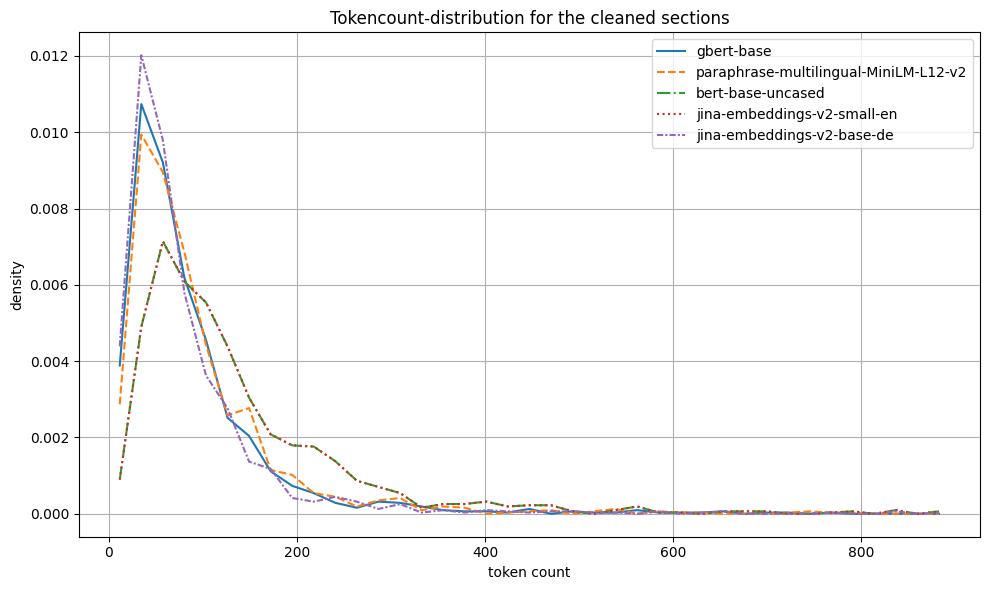

In [33]:
contract_sections_clean = pd.read_pickle('../data/contract_sections_clean.pkl')
df = contract_sections_clean.copy()
# Deine Spalte zum Analysieren
# column = "clean_section_content"

# # Modellnamen und URLs
# model_names = [
#     "gbert-base",
#     "paraphrase-multilingual-MiniLM-L12-v2",
#     "bert-base-uncased",
#     "jina-embeddings-v2-small-en",
#     "jina-embeddings-v2-base-de"
# ]

# model_urls = [
#     "deepset/gbert-base",
#     "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
#     "bert-base-uncased",
#     "jinaai/jina-embeddings-v2-small-en",
#     "jinaai/jina-embeddings-v2-base-de"
# ]

# Tokenizer vorbereiten
tokenizers = {}

for name, url in zip(model_names, model_urls):
    tokenizers[name] = AutoTokenizer.from_pretrained(url)

# Tokenlängen erfassen
token_counts = {}

for name, tokenizer in tokenizers.items():
    token_counts[name] = df["clean_section_content"].fillna("").apply(lambda x: len(tokenizer.tokenize(x)))

# Plot: Verteilung der Tokenanzahl (99%-Quantil)
plt.figure(figsize=(10, 6))
max_x = max(token_counts[name].quantile(0.99) for name in token_counts)
bins = np.linspace(0, max_x, 40)
styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]


for (name, data), style in zip(token_counts.items(), styles):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist, label=name, linestyle=style)

plt.title(f"Tokencount-distribution for the cleaned sections")
plt.xlabel("token count")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

del  max_x , df, bins, styles, hist, bin_centers, bin_edges, token_counts, tokenizers

## 4.2 Model Assembly and Pooling start
In this section, we load a selection of transformer-based language models and prepare them for use with the Sentence Transformers framework. Each model is wrapped with a pooling strategy to generate fixed-size sentence embeddings.
Each model is assembled using the Sentence Transformers Transformer + Pooling modules. We store each configuration in a dictionary (models_dict) using a key that includes the model name and pooling strategy (e.g., base_gbert_sentence_cls).
If the RAM is not sufficient there is also the Option to safe all the build models for reuse without reloading from Hugging Face however when doing so they have to be excluded from the git repository since they are to big.
This setup provides a flexible and consistent framework to benchmark **15 different transformer** models and pooling strategies for downstream semantic matching tasks.


In [34]:
models_store_as = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean", "max"]

# Dictionary zur Sammlung der Modelle
models_dict = {}
models_urls = {}
models_strat = {}


for model_in, model_out in zip(model_urls, models_store_as):
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Assable model: {model_out}, with word-embedding-odel: '{model_in}' and pooling strategy: {pool_strat}")

        cls = pool_strat == "cls"
        mean = pool_strat == "mean"
        maxi = pool_strat == "max"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=maxi,
        )

        model_section_embedding= SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Key z. B. "base_gbert_sentence_cls"
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model_section_embedding
        models_urls[dict_key] = model_in
        models_strat[dict_key] = pool_strat


        # Optional speichern:
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# Ausgabe der geladenen Modelle
print("Geladene Modelle:", list(models_dict.keys()))


Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: cls
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: mean
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: max
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: cls
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: mean
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: max
Assable model: bert_base_uncased_sentence, with word-embedding-odel: 'bert-base-uncased' and pooling strategy: cls
Assable model: bert_base_uncased_sentence, with word-embedding-odel

## 4.3 Matching Contract Sections to Catalog Entries Using Embeddings
In this section, we match contract sections to the most relevant catalog entries using vector-based semantic similarity. For each embedding model in our comparison, we perform the following steps:

Embedding Generation:
We encode the contract sections (clean_section_content) and the catalog examples (example) using the selected embedding model.

Similarity Computation:
We calculate the cosine similarity between each section embedding and all catalog entry embeddings. For each section, we select the catalog entry with the highest similarity score as the predicted match.

Ground Truth Comparison:
We compare the predicted catalog ID against the ground truth (true_catalog_id) to assess whether the top match is correct.

Evaluation with ROC Curve:
Using the cosine similarity scores as prediction confidence, we compute an ROC curve and the AUC (Area Under Curve) to measure how well the model distinguishes correct from incorrect matches.

Threshold Optimization:
We determine an optimal similarity threshold based on the ROC curve (max(TPR - 0.5 × FPR)), which we then use to classify matches as valid or invalid.

Postprocessing:
Matches below the threshold are marked as invalid by assigning a dummy catalog ID (-99), enabling further analysis and filtering.

This analysis is repeated for each model in our benchmark set. The results help us compare model performance and select the best embedding model for semantic contract section matching.

In [35]:

df = contract_sections_clean_labeled_manually.copy()

df_no_label = df[["contract","paragraph","section","clean_section_content"]].copy()
display(df_no_label)

df_true_label = df[["contract","paragraph","section","clean_section_content","catalog_id"]].copy()
df_true_label.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
display(df_true_label)

df_true_label["true_catalog_id"] = df_true_label["true_catalog_id"].astype(int)
cols = ["contract","paragraph","section","clean_section_content"]
display(catalogue_clean)

del df



,contract,paragraph,section,clean_section_content
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...
2,4,3.,3.2,support und sla sap erbringt support für den c...
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...
...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...


,contract,paragraph,section,clean_section_content,true_catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,dieser vertrag unterliegt dem recht der bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,gerichtsstand für alle streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",dieser vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,sollte eine bestimmung dieses vertrages unwirk...,75


In [36]:

models_thresholds = {}
tab_contents = []
df = df_no_label.copy()
df_cols = ["contract","paragraph","section","clean_section_content"]

for model_name in models_dict:
    model_selected = models_dict[model_name]
    df = add_embed_text_column(df, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}")
    cat = add_embed_text_column(catalogue_clean, text_column = "example", model = model_selected, target_column = "emb")
    df_cols.append(f"section_em_{model_name}")
    #df  = df[df_cols]

    X = np.vstack(df[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    new_cols = pd.DataFrame({
    f"matched_example_index_{model_name}": best_match_idx,
    f"similarity_percent_{model_name}": best_match_score,
    f"matched_example_text_{model_name}": cat.loc[best_match_idx, "example"].values,
    f"matched_example_topic_{model_name}": cat.loc[best_match_idx, "section_topic"].values,
    f"matched_paragraph_{model_name}": cat.loc[best_match_idx, "paragraph_topic"].values,
    f"matched_catalog_id_{model_name}": cat.loc[best_match_idx, "catalog_id"].values,
    })

    df = pd.concat([df.reset_index(drop=True), new_cols.reset_index(drop=True)], axis=1)
    del new_cols

    # # print(df_true_match["true_catalog_id"].dtype)
    # print(df_to_match[f"matched_catalog_id_{model_name}"].dtype)    
    df_pred_label = df

    y_true = (df_true_label["true_catalog_id"].values == df_pred_label[f"matched_catalog_id_{model_name}"].values).astype(int)
    if np.sum(y_true) == 0:
        print(f"No match found at all with model: {model_name}")
    y_scores = df_pred_label[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1
    # print("Verteilung der Klassen in y_true:")
    # print(np.unique(y_true, return_counts=True)) U+1F644


    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    custom_score = tpr - 0.5 * fpr
    optimal_idx = np.argmax(custom_score)
    optimal_threshold = thresholds[optimal_idx]
    
    output = widgets.Output()
    with output:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
        plt.legend(loc='lower right')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        tab_contents.append((title, output))
    # Optimaler Threshold = max(tpr - fpr)

    # print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df.loc[~df[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    del y_true , y_scores
    models_thresholds[model_name] = optimal_threshold

tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)
display(tab_widget)


matches_all_models = df.copy()
del df, df_cols ,df_pred_label, optimal_threshold, optimal_idx, fpr, tpr, thresholds, tab_widget, X,Y, similarity_matrix, similarity_percent, best_match_idx, best_match_score


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

No match found at all with model: jina_base_de_sentence_mean



/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


In [37]:
df = matches_all_models.copy()


# import ipywidgets as widgets
# from sklearn.metrics import classification_report
# from IPython.display import display
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

df = matches_all_models.copy()
tabs = []
titles = []
recalls_weighted = []

for model_name in models_dict:
    pred_col = f"matched_catalog_id_{model_name}"
    y_true = df_true_label["true_catalog_id"]
    y_pred = df[pred_col]

    # Berechne recall (weighted)
    recall_w = recall_score(y_true, y_pred, average='weighted')
    recalls_weighted.append(recall_w)

    output = widgets.Output()
    with output:
        print(f"Classification Report for {model_name}")
        print(classification_report(y_true, y_pred, digits=2))

    tabs.append(output)
    titles.append(model_name)

best_recall_idx = int(max(range(len(recalls_weighted)), key=lambda i: recalls_weighted[i]))


# Tab-Widget erzeugen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)
del df, tabs, titles, pred_col, y_true, y_pred,  tab_widget, recalls_weighted, model_name, output, best_recall_idx,  i, title


In [38]:
tab_contents = []
df = matches_all_models.copy()

for model_name in models_dict:
    output = widgets.Output()
    with output:
        # Daten vorbereiten
        df_matched_ids = df[["contract", "paragraph", "section", "clean_section_content", f"matched_catalog_id_{model_name}"]]
        y_true = df_true_label["true_catalog_id"].astype(str)
        y_pred = df[f"matched_catalog_id_{model_name}"].astype(str)

        # Gemeinsame, sortierte Label-Liste für Achsen
        # Gemeinsame Labels sammeln
        all_labels_set = set(y_true).union(set(y_pred))

        # Nach int sortieren, dann in String zurückwandeln
        all_labels = [str(x) for x in sorted(map(int, all_labels_set))]
        cm = confusion_matrix(y_true, y_pred, labels=all_labels)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    
    tab_contents.append((model_name, output))

# Tabs erzeugen
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)
del df, tab_contents


In [39]:

metrics = []
df = matches_all_models.copy()

for model_name in models_dict:
    y_pred = df[f"matched_catalog_id_{model_name}"]
    y_true = df_true_label["true_catalog_id"]

    metrics.append({
            "model": model_name,
            "recall (macro)": recall_score(y_true, y_pred, average='macro'),
            "recall (weighted)": recall_score(y_true, y_pred, average='weighted'),
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1 (macro)": f1_score(y_true, y_pred, average='macro'),
            "F1 (weighted)": f1_score(y_true, y_pred, average='weighted')
        })




df = pd.DataFrame(metrics).sort_values("recall (weighted)", ascending=False)
thresholds = pd.DataFrame(models_thresholds.items(), columns=["model", "optimal_threshold"])
models_urls = pd.DataFrame(models_urls.items(), columns=["model", "model_url"])
models_pooling = pd.DataFrame(models_strat.items(), columns=["model", "pooling_strategy"])
df = df.merge(models_urls, on="model", how="left").merge(models_pooling, on="model", how="left").merge(thresholds, on="model", how="left")

display(df)
best_models = df.copy()
best_models.to_pickle("../data/best_models.pkl")
best_models.to_excel("../data/best_models.xlsx")
del metrics, df, y_pred, y_true, thresholds, model_urls, models_pooling, best_models


,model,recall (macro),recall (weighted),Accuracy,F1 (macro),F1 (weighted),model_url,pooling_strategy,optimal_threshold
0,multilingual_paraphrase_sentence_mean,0.353846,0.375000,0.375000,0.299487,0.325000,sentence-transformers/paraphrase-multilingual-...,mean,0.5818
1,multilingual_paraphrase_sentence_max,0.235294,0.265625,0.265625,0.192437,0.225298,sentence-transformers/paraphrase-multilingual-...,max,0.8587
2,base_gbert_sentence_mean,0.224638,0.250000,0.250000,0.187716,0.212798,deepset/gbert-base,mean,0.7840
3,multilingual_paraphrase_sentence_cls,0.171875,0.187500,0.187500,0.153646,0.169271,sentence-transformers/paraphrase-multilingual-...,cls,0.8052
4,base_gbert_sentence_max,0.161765,0.171875,0.171875,0.133333,0.141667,deepset/gbert-base,max,0.9375
5,bert_base_uncased_sentence_max,0.146154,0.171875,0.171875,0.123528,0.151500,bert-base-uncased,max,0.9713
6,base_gbert_sentence_cls,0.132353,0.140625,0.140625,0.094363,0.100260,deepset/gbert-base,cls,0.8312
7,bert_base_uncased_sentence_mean,0.100000,0.109375,0.109375,0.084615,0.096354,bert-base-uncased,mean,0.9740
8,jina_small_en_sentence_max,0.086957,0.109375,0.109375,0.082126,0.104167,jinaai/jina-embeddings-v2-small-en,max,0.9271
9,jina_small_en_sentence_cls,0.074627,0.093750,0.093750,0.057214,0.075521,jinaai/jina-embeddings-v2-small-en,cls,0.8924


# 5. Finetuning

In [40]:
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))

,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


In [41]:

catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
display(catalogue_clean.head(5))


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


In [42]:

best_models = pd.read_excel("../data/best_models.xlsx")
best_model_info = best_models.iloc[0]

del best_models

In [43]:

tabs = []
titles = []

out0 = widgets.Output()
with out0:
    display(best_model_info.to_frame().T)
tabs.append(out0)
titles.append("Best Model Results")

out1 = widgets.Output()
with out1:
    print(f'Model: {best_model_info["model"]}') 
    print(f'Embeddings from: {best_model_info["model_url"]}')
    print(models_dict[best_model_info["model"]][0].auto_model)
tabs.append(out1)
titles.append("Word Embeddings")

# Tab 2: Pooling Strategy
out2 = widgets.Output()
with out2:
    print("Pooling Strategy:")
    print("#####################################################")
    print(f'Strategy: {best_model_info["pooling_strategy"]}')
    print(models_dict[best_model_info["model"]][1])  # Pooling Layer
    print("\nPooling.forward source code:\n")
    print(inspect.getsource(Pooling.forward))
tabs.append(out2)
titles.append("Pooling")

# Tab 3: Threshold

# Tabs anzeigen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)


In [44]:
pooling_strategy = best_model_info["pooling_strategy"]
word_embedding_model = models_dict[best_model_info["model"]][0]

cls = pooling_strategy == "cls"
mean = pooling_strategy == "mean"
maxim = pooling_strategy == "max"

pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=cls,
    pooling_mode_mean_tokens=mean,
    pooling_mode_max_tokens=maxim,
)

best_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


print(catalogue_clean["example"])
pooling_strategy, word_embedding_model, cls, mean, maxim, pooling_model,


0     im festpreis von € sind sämtliche leistungen e...
1     der kunde zahlt eine monatliche pauschale von ...
2     die vergütung ist in drei raten zahlbar bei pr...
3     alle preise verstehen sich in euro zuzüglich g...
4     reise und übernachtungskosten werden nur ersta...
                            ...                        
71    dieser vertrag unterliegt dem recht der bundes...
72    gerichtsstand für alle streitigkeiten aus oder...
73    dieser vertrag wird in deutscher und englische...
74    sollte eine bestimmung dieses vertrages unwirk...
75    keine der parteien haftet für die nichterfüllu...
Name: example, Length: 76, dtype: object


('mean',
 Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel ,
 False,
 True,
 False,
 Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False}))

In [45]:
catalogue_embeddings = add_embed_text_column(catalogue_clean, text_column="example", model=best_model, target_column="emb")
label_embeddings = torch.tensor(np.stack(catalogue_embeddings["emb"].to_list())).float()
print(label_embeddings)
del  catalogue_embeddings


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

tensor([[-0.0435, -0.0498, -0.1699,  ..., -0.2215,  0.2212, -0.1053],
        [ 0.0433, -0.0763, -0.1887,  ...,  0.0786,  0.0460, -0.2305],
        [-0.0213,  0.0892, -0.0744,  ..., -0.0886,  0.3071,  0.0552],
        ...,
        [ 0.0713,  0.2938, -0.1524,  ..., -0.2776,  0.0438,  0.0155],
        [-0.0685,  0.0929, -0.2396,  ..., -0.1415,  0.4333, -0.0359],
        [-0.0226, -0.0127, -0.0783,  ..., -0.0964,  0.3193, -0.1646]])


In [46]:
# class CosineMapper(nn.Module):
#     def __init__(
#         self,
#         model_name= best_model["model_url"],
#         label_embeddings = label_embeddings,
#         pooling= best_model["pooling_strategy"],
#         threshold= best_model["optimal_threshold"]
#     ):
#         super().__init__()
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name)
#         config = AutoConfig.from_pretrained(model_name)
#         self.bert = AutoModel.from_pretrained(model_name,config = config)  # Verwende 'gelu' als Aktivierungsfunktion
#         self.pooling = pooling
#         self.threshold = threshold

#         self.label_embeddings = nn.Parameter(label_embeddings, requires_grad=False)  # z. B. aus SentenceTransformer
#         self.activation = nn.GELU()  # Verwende 'gelu' als Aktivierungsfunktion

#         self.dropout = nn.Dropout(0.5)

#     def forward(self, texts,return_embedding = False  ):
#         if isinstance(texts, str):
#             texts = [texts]

#         inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
#         outputs = self.bert(**inputs)
#         token_embeddings = outputs.last_hidden_state  # (B, T, H)

#         # Pooling
#         if self.pooling == "cls":
#             pooled = token_embeddings[:, 0]
#         elif self.pooling == "max":
#             mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.shape).float()
#             token_embeddings[mask == 0] = -1e9
#             pooled = torch.max(token_embeddings, dim=1)[0]
#         elif self.pooling == "mean":
#             mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.shape).float()
#             summed = torch.sum(token_embeddings * mask, dim=1)
#             counts = mask.sum(dim=1).clamp(min=1e-9)
#             pooled = summed / counts
#         else:
#             raise ValueError("Unknown pooling method")

#         pooled = self.dropout(pooled)
#         if return_embedding:
#             return pooled 

#         # Cosine similarity zu allen Labels
#         normalized_input = nn.functional.normalize(pooled, dim=1)
#         normalized_labels = nn.functional.normalize(self.label_embeddings, dim=1)

#         cosine_sim = torch.matmul(normalized_input, normalized_labels.T)  # (B, num_labels)
#         return cosine_sim

#     def predict(self, texts, top_k: int = 1, return_scores: bool = False):
#         with torch.no_grad():
#             scores = self.forward(texts)

#         if return_scores:
#             # Gib Top-k Indizes (+1) und Scores zurück
#             topk_scores, topk_indices = torch.topk(scores, k=top_k, dim=1)
#             results = []
#             for indices, values in zip(topk_indices, topk_scores):
#                 results.append([(i.item(), round(s.item(), 4)) for i, s in zip(indices, values)])
#             return results if len(results) > 1 else results[0]

#         else:
#             # Gib nur Index (+1) der besten Klasse zurück
#             preds = torch.argmax(scores, dim=1)
#             result = (preds+1 ).tolist()
#             return result[0] if len(result) == 1 else result


In [47]:
url                 = best_model_info["model_url"]
pooling_strategy    = best_model_info["pooling_strategy"]
threshold           = best_model_info["optimal_threshold"]


best_model_cosine_mapper = CosineMapper(
    model_name= url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)
best_model_cosine_mapper


CosineMapper(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_aff

In [48]:
example = contract_sections_clean_labeled_manually["clean_section_content"][23]
print(f"{example[:200]}... -->")
best_model_cosine_mapper(example)

alyne haftet gleichgültig aus welchem rechtsgrund nicht für mittelbare schäden und oder folgeschäden insbesondere nicht für entgangenen gewinn und zinsverluste es sei denn dass ein solcher schaden dur... -->


tensor([[ 0.1036, -0.0104,  0.1958,  0.0938,  0.1453,  0.0337,  0.0143,  0.1447,
          0.1308, -0.0510,  0.0690,  0.1235, -0.0893,  0.0862, -0.0282,  0.0687,
          0.0615,  0.1123,  0.1342,  0.0460,  0.0943,  0.1894,  0.1042,  0.1416,
          0.2309,  0.2214,  0.0683,  0.0441,  0.1829, -0.0189,  0.2106, -0.0981,
         -0.0060,  0.0540,  0.1006,  0.0152,  0.0116,  0.0438, -0.0332,  0.0397,
          0.1142, -0.0299,  0.0128,  0.0371,  0.0789,  0.1656,  0.1803,  0.2691,
          0.1467,  0.1151,  0.0306,  0.1861,  0.0299,  0.1641,  0.0388,  0.1913,
         -0.1052, -0.0114, -0.0043, -0.0420,  0.1768,  0.4339,  0.4195,  0.2807,
          0.1647,  0.1804,  0.0465,  0.0021,  0.2455,  0.1936,  0.0946,  0.1392,
          0.2156,  0.1596,  0.2742,  0.1901]], grad_fn=<MmBackward0>)

In [49]:
df = contract_sections_clean_labeled_manually.copy()

# Labels (int) extrahieren
df["label"] = df["catalog_id"].astype(int)

# Listen erzeugen
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()


# Split in Train/Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3,  random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    val_texts,
    val_labels,
    test_size=0.5,
    random_state=42
)


# class TextLabelDataset(Dataset):
#     def __init__(self, texts, labels):
#         self.texts = texts
#         self.labels = labels

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return {
#             "text": self.texts[idx],
#             "label": self.labels[idx]
#         }

# train loader
train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
del train_texts, train_labels, train_dataset

# validation loader
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)
del val_texts, val_labels, val_dataset

# test loader
test_dataset = TextLabelDataset(test_texts, test_labels)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)
del test_texts, test_labels, test_dataset

for batch in train_loader:
    print(batch["text"][0])
    print(batch["label"][0])
    break

die in ziff aufgeführten leistungen werden durch die im produktschein oder individualvertrag vereinbarte pauschalierte abgegolten die fahrtkosten und fahrtzeiten sowie übernachtungskosten und tagesspesen werden gesondert in rechnung gestellt csb behält sich das recht vor im wartungsfalle bei nicht aktueller programmversion dem kunden die aktuelle programmversion zu liefern es obliegt in diesem fall dem kunden die notwendigen systemtechnischen voraussetzungen für die lauffähigkeit der neuen version auf eigene kosten zu schaffen
tensor(15)


In [50]:
epochs = 1000  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5) 
best_model_cosine_mapper.train()
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
best_model_cosine_mapper.return_scores=True


for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] -1
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts)  # cosine similarity (B, num_labels)
        loss = criterion(cos_sims, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] -1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break


del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels



Epoch 1, Training Loss: 4.1486
Epoch 1, Validation Loss: 4.0870
--> Model saved!
Epoch 2, Training Loss: 4.0987
Epoch 2, Validation Loss: 4.0682
--> Model saved!
Epoch 3, Training Loss: 4.0537
Epoch 3, Validation Loss: 4.0510
--> Model saved!
Epoch 4, Training Loss: 4.0183
Epoch 4, Validation Loss: 4.0467
--> Model saved!
Epoch 5, Training Loss: 3.9759
Epoch 5, Validation Loss: 4.0543
Epoch 6, Training Loss: 3.9639
Epoch 6, Validation Loss: 4.0584
Epoch 7, Training Loss: 3.9461
Epoch 7, Validation Loss: 4.0550
Epoch 8, Training Loss: 3.9302
Epoch 8, Validation Loss: 4.0505
Epoch 9, Training Loss: 3.9111
Epoch 9, Validation Loss: 4.0458
--> Model saved!
Epoch 10, Training Loss: 3.9167
Epoch 10, Validation Loss: 4.0416
--> Model saved!
Epoch 11, Training Loss: 3.8935
Epoch 11, Validation Loss: 4.0420
Epoch 12, Training Loss: 3.8876
Epoch 12, Validation Loss: 4.0453
Epoch 13, Training Loss: 3.8882
Epoch 13, Validation Loss: 4.0449
Epoch 14, Training Loss: 3.8866
Epoch 14, Validation Loss:

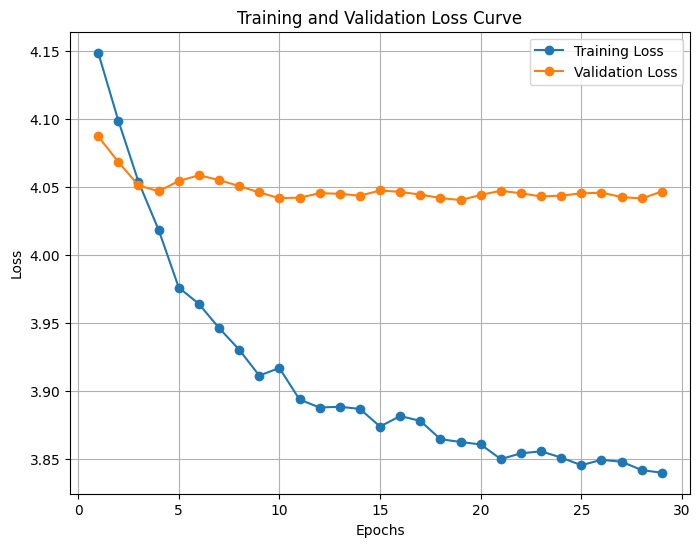

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()
# Nach dem Training: bestes Modell laden


In [52]:

best_model_cosine_mapper.load_state_dict(torch.load("best_model_cosine_mapper_trained_with_test.pth"))
best_model_cosine_mapper.eval()
best_model_cosine_mapper.return_scores = False


# Listen zum Speichern der Vorhersagen
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        texts = batch["text"]
        labels = batch["label"].tolist()

        preds =best_model_cosine_mapper.predict(texts)
        print(labels)
        print(preds)
        
        all_test_preds.extend(preds)
        all_test_labels.extend(labels)






cm = confusion_matrix(all_test_labels, all_test_preds)

all_labels = sorted(set(all_test_labels) | set(all_test_preds))  # Vereinigung beider Mengen


tabs = []
titles = []

out0 = widgets.Output()
with out0:
    print(classification_report(all_test_labels, all_test_preds, digits=2))
tabs.append(out0)
titles.append("Calssification Report")

out1 = widgets.Output()
with out1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: best_model_cosine_mapper_trained_with_test")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

tabs.append(out1)
titles.append("Confusion Matrix")


# Tabs anzeigen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)


[12, 1, 58, 3, 71, 24, 28, 63, 29, 35]
[45, 4, 13, 61, 72, 26, 28, 62, 29, 13]


# Ohne TEST 

In [53]:
#del best_model_cosine_mapper

best_model_cosine_mapper = CosineMapper(
    model_name= url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)


In [54]:

df = contract_sections_clean_labeled_manually.copy()

# Labels (int) extrahieren
df["label"] = df["catalog_id"].astype(int)

# Listen erzeugen
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()


# Split in Train/Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3,  random_state=42
)



# class TextLabelDataset(Dataset):
#     def __init__(self, texts, labels):
#         self.texts = texts
#         self.labels = labels

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return {
#             "text": self.texts[idx],
#             "label": self.labels[idx]
#         }

# train loader
train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
del train_texts, train_labels, train_dataset

# validation loader
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)
del val_texts, val_labels, val_dataset


In [55]:
epochs = 1000  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5) 
best_model_cosine_mapper.train()
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
best_model_cosine_mapper.return_scores=True


for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] -1
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts)  # cosine similarity (B, num_labels)
        loss = criterion(cos_sims, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] -1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break


del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels



Epoch 1, Training Loss: 4.1451
Epoch 1, Validation Loss: 4.1253
--> Model saved!
Epoch 2, Training Loss: 4.0834
Epoch 2, Validation Loss: 4.1068
--> Model saved!
Epoch 3, Training Loss: 4.0444
Epoch 3, Validation Loss: 4.0972
--> Model saved!
Epoch 4, Training Loss: 4.0203
Epoch 4, Validation Loss: 4.0973
Epoch 5, Training Loss: 3.9783
Epoch 5, Validation Loss: 4.0998
Epoch 6, Training Loss: 3.9657
Epoch 6, Validation Loss: 4.1031
Epoch 7, Training Loss: 3.9513
Epoch 7, Validation Loss: 4.1011
Epoch 8, Training Loss: 3.9457
Epoch 8, Validation Loss: 4.0974
Epoch 9, Training Loss: 3.9141
Epoch 9, Validation Loss: 4.0929
--> Model saved!
Epoch 10, Training Loss: 3.9133
Epoch 10, Validation Loss: 4.0967
Epoch 11, Training Loss: 3.9073
Epoch 11, Validation Loss: 4.1086
Epoch 12, Training Loss: 3.8933
Epoch 12, Validation Loss: 4.1177
Epoch 13, Training Loss: 3.8902
Epoch 13, Validation Loss: 4.1163
Epoch 14, Training Loss: 3.8786
Epoch 14, Validation Loss: 4.1091
Epoch 15, Training Loss: 3

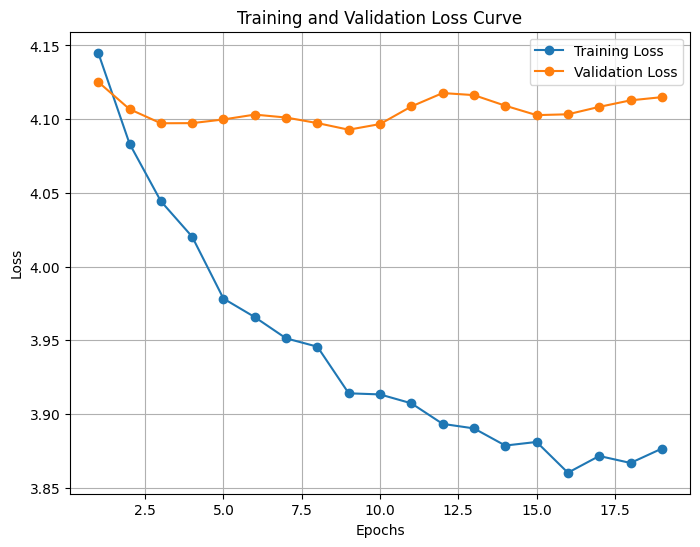

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()
# Nach dem Training: bestes Modell laden


# 6. Application + Textual checking of requirements 

In [57]:

contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
df = contract_sections_clean_labeled_manually.copy()

catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
display(catalogue_clean.head(5))

df = df[pd.notna(df["contract"])]
contracts_with_labels = df["contract"].astype(int).unique()
del df, contract_sections_clean_labeled_manually

all_contracts= pd.read_pickle("../data/contract_contents_german_only")
df = all_contracts.copy()
df["contract"] = df["contract"].astype(int)
contracts_without_labels = df[~df["contract"].isin(contracts_with_labels)]["contract"].unique().tolist()
exp_contract = contracts_without_labels[0]
print(exp_contract)
exp = df[df["contract"] == exp_contract]  # Beispiel: zufällige 1 Verträge
display(exp)

contract_sections_clean_without_labels = df[df["contract"].isin(contracts_without_labels)]


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


1


,contract,content
0,1,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...


In [58]:

best_models = pd.read_pickle("../data/best_models.pkl")
best_model_info = best_models.iloc[0]

url                 = best_model_info["model_url"]
pooling_strategy    = best_model_info["pooling_strategy"]
threshold           = best_model_info["optimal_threshold"]


best_model_cosine_mapper_untrained = CosineMapper(
    model_name= url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)

In [59]:



# class SectionTopicPredictor:
#     def __init__(self, model, catalogue_clean):
#         """
#         Parameters:
#         - model: dein CosineMapper mit predict()-Methode
#         - catalogue_clean: DataFrame mit Spalte 'section_topic'
#         """
#         self.model = model
#         self.catalogue_clean = catalogue_clean

#     def _preprocess_contract(self, text):
#         """
#         Führt Paragraph- und Abschnittsextraktion + Cleaning durch.
#         """
#         fake_row = {"content": text, "contract": 1}
#         sections = extract_paragraphs_and_sections(fake_row)  # -> List[Dict]
#         for section in sections:
#             section["clean_section_content"] = clean_sections_and_paragraphs(section["section_content"])
#         return sections

#     def predict_contract(self, contract_text, return_topic_score=False):
#         """
#         contract_text: Volltext eines Vertrags (String)

#         Rückgabe: DataFrame mit Feldern aus den extrahierten Sections + 'predicted_topic'
#         """
#         cont_exp = self._preprocess_contract(contract_text)
#         return self.predict_sections(cont_exp, return_topic_score=return_topic_score)

#     def predict_sections(self, cont_exp, return_topic_score=False):
#         """
#         cont_exp: Liste von Dicts mit mindestens 'section', 'section_content', 'clean_section_content'

#         Rückgabe: DataFrame mit allen ursprünglichen Feldern + 'predicted_topic'
#         """
#         records = []

#         for section in cont_exp:
#             cleaned = section['clean_section_content']
# #
#             if return_topic_score:
#                 model_output = self.model.predict(cleaned, return_scores=True)

#                 top = max(model_output, key=lambda x: x[1])
#                 label = top[0]
#                 score = top[1]
#                 index = int(label) - 1 
#             else:
#                 label = self.model.predict(cleaned, return_scores=False)
#                 index = int(label) - 1
#                 score = None

#             topic = self.catalogue_clean["section_topic"].iloc[index]

#             record = {**section, "predicted_topic": topic}
#             if return_topic_score:
#                 record["score"] = score

#             records.append(record)

#         return pd.DataFrame(records)
    


In [60]:

top_scores = []
top_paragraphs = []
top_sections = []
top_indexes = []

topic_predictor = SectionTopicPredictor(best_model_cosine_mapper_untrained, catalogue_clean)


# df = contract_sections_clean_without_labels.copy()

for i in contracts_without_labels:

    contract = contract_sections_clean_without_labels.loc[contract_sections_clean_without_labels["contract"] == i, "content"].iloc[0]
    df = topic_predictor.predict_contract(contract, return_topic_score=True)

    # Ausgabe (optional)
    #print(df.sort_values("score", ascending=False).head(1))
    df = df.sort_values("score", ascending=False)

    top_score = df.iloc[0]["score"]
    top_paragraph = df.iloc[0]["paragraph"]
    top_section = df.iloc[0]["section"]
    index_topscore = df[df["section"] == top_section].index[0]  # Index des Top-Scores
    top_scores.append(top_score)  
    top_paragraphs.append(top_paragraph)
    top_sections.append(top_section)  
    top_indexes.append(index_topscore)  

    
# Nach der Verarbeitung – temporäre Variablen löschen
del i, df, contract, top_score, top_section, index_topscore



In [61]:
df_top_predictions = pd.DataFrame({
    "contract": contracts_without_labels,
    "prargaph": top_paragraphs,
    "section": top_sections,
    "score": top_scores,
    "index": top_indexes
})

display(df_top_predictions.sort_values("score", ascending= False))
    

,contract,prargaph,section,score,index
5,16,14.,14.2,0.6780,40
4,15,§ 4,4.2,0.5981,16
1,3,1.,1.5,0.5126,4
0,1,§ 1,1.1,0.4807,0
2,9,1.,1.1,0.4322,0
3,10,§ 1,(1),0.2733,0


In [62]:
df = contract_sections_clean_without_labels.copy()

exp = df[df["contract"] == 16] 

for i in range(len(exp)):  
    text = exp["content"].values[0]
    df = topic_predictor.predict_contract(text, return_topic_score=True)
    #print(predicted_df)

# Gute Kombi z.b contract 26 section 73
exp_section = 35 #random.randint(0, len(predicted_df) - 1)

topic = df.loc[exp_section, "predicted_topic"]
content = df.loc[exp_section, "section_content"]
score = df.loc[exp_section, "score"]

print("? Predicted Topic:\n", topic)
print("! Section Content:\n", content)
# Print Section Content in green color
print("\033[92m🔥 Score:\033[0m", score)

labeled_sections_example_contract = df.copy()
del df, exp, text, exp_section, topic, content, score

? Predicted Topic:
 Ist geregelt, wo die Kundendaten gespeichert/verarbeitet werden und unter welchen Bedingungen eine Übertragung in Drittstaaten zulässig ist?
! Section Content:
 12.1 Die Parteien sind verp#ichtet, alle ihnen im Zusammenhang mit diesem Vertrag bekannt gewordenen oder bekannt werdenden Informationen über die jeweils andere Partei, die als vertraulich gekennzeichnet werden oder anhand sonstiger Umstände als Geschäfts- und Betriebsgeheimnisse (im Folgenden: „vertrauliche Informationen“) erkennbar sind, dauerhaft geheim zu halten, nicht an Dritte weiterzugeben, aufzuzeichnen oder in anderer Weise zu verwerten, sofern die jeweils andere Partei der Offenlegung oder Verwendung nicht ausdrücklich und schriftlich zugestimmt hat oder die Informationen aufgrund Gesetzes, Gerichtsentscheidung oder einer Verwaltungsentscheidung offengelegt werden müssen.
🔥 Score: 0.6236


In [63]:

df = labeled_sections_example_contract.copy()

display(df.head(5))
scores = df.sort_values("score")


display(df[["predicted_topic","section_content","score"]].head(5))
del df

,contract,paragraph,paragraph_content,section,section_content,clean_section_content,predicted_topic,score
0,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,diese vertragsbedingungen gelten für die nutzu...,Werden die Folgen der Abnahme beschrieben (z.B...,0.4825
1,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,die software wird vom anbieter als saas bzw cl...,Werden qualitative Anforderungen oder Leistung...,0.4050
2,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,diese vertragsbedingungen gelten ausschließlic...,Sind die Rechte des Kunden im Gewährleistungsf...,0.5386
3,1,2.,2. Art und Umfang der Leistung Der Anbieter st...,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,art und umfang der leistung der anbieter stell...,"Hat der Kunde das Recht, die Einhaltung der Si...",0.5042
4,1,3.,3. Verfügbarkeit der Software 3.1 Der Anbieter...,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...",der anbieter weist den kunden darauf hin dass ...,"Wird gefordert, dass bei jeder genehmigten Änd...",0.5285


,predicted_topic,section_content,score
0,Werden die Folgen der Abnahme beschrieben (z.B...,1.1 Diese Vertragsbedingungen gelten für die N...,0.4825
1,Werden qualitative Anforderungen oder Leistung...,1.2 Die Software wird vom Anbieter als SaaS- b...,0.4050
2,Sind die Rechte des Kunden im Gewährleistungsf...,1.3 Diese Vertragsbedingungen gelten ausschlie...,0.5386
3,"Hat der Kunde das Recht, die Einhaltung der Si...",2. Art und Umfang der Leistung Der Anbieter st...,0.5042
4,"Wird gefordert, dass bei jeder genehmigten Änd...","3.1 Der Anbieter weist den Kunden darauf hin, ...",0.5285


In [64]:

client = OpenAI(api_key=OpenAiKey)

# def check_core_aspects_with_llm(section_text, core_aspects, client = client, model="gpt-4o-mini", sleep_between_calls=1.5):
#     aspects_list = "\n- " + "\n- ".join(core_aspects)
#     prompt = f"""Du bist ein Vertragsexperte. Prüfe den folgenden Vertragstext auf die Einhaltung der folgenden Kernanforderungen (Core Aspects).

# Gib als Ergebnis für jeden einzelnen Punkt einen Erfüllungsgrad von 0 bis 1 an (0 = nicht erfüllt, 1 = voll erfüllt, 0.5 = teilweise erfüllt). Gib zusätzlich eine durchschnittliche Erfüllungsquote in Prozent für alle Core Aspects an.

# Vertragstext:
# {section_text}

# Core Aspects:{aspects_list}

# Antwortformat (nur JSON):
# {{
# "core_aspect_scores": {{
#     "Aspekt 1": 1,
#     "Aspekt 2": 0.5
# }},
# "average_fulfillment_percent": 76.5
# }}"""

#     try:
#         response = client.chat.completions.create(
#             model=model,
#             messages=[{"role": "user", "content": prompt}],
#             temperature=0.2
#         )
#         return response.choices[0].message.content
#     except Exception as e:
#         print("API-Fehler:", e)
#         return None
#     finally:
#         time.sleep(sleep_between_calls)


In [65]:
df = labeled_sections_example_contract.copy()
catalogue_clean_with_aspects = pd.read_excel("../data/catalogue_clean_with_aspects.xlsx")


df = df.merge(
    catalogue_clean_with_aspects[["section_topic", "core_aspects"]],
    left_on="predicted_topic",
    right_on="section_topic",
    how="left")

# df_eval = df_eval[["contract", "paragraph", "section", "clean_section_content", "predicted_topic", "core_aspects"]]
df = df[["contract", "paragraph", "section", "section_content", "predicted_topic","score", "core_aspects"]]

display(df.head(5) )

labeled_sections_example_contract_with_critertia = df.copy()
del df, catalogue_clean_with_aspects

,contract,paragraph,section,section_content,predicted_topic,score,core_aspects
0,1,1.,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,Werden die Folgen der Abnahme beschrieben (z.B...,0.4825,Die Fälligkeit der Schlusszahlung ist an die e...
1,1,1.,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,Werden qualitative Anforderungen oder Leistung...,0.4050,Meilensteinen sind konkrete Ergebnislieferunge...
2,1,1.,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,Sind die Rechte des Kunden im Gewährleistungsf...,0.5386,Die Rechte des Kunden im Gewährleistungsfall s...
3,1,2.,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,"Hat der Kunde das Recht, die Einhaltung der Si...",0.5042,Kunde hat vertraglich geregeltes Recht auf Nac...
4,1,3.,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...","Wird gefordert, dass bei jeder genehmigten Änd...",0.5285,Für jede genehmigte Leistungsänderung wird ein...


In [66]:



#Bewertungsfunktion
# def evaluate_fullfillment_on_criteria(row, content_column="section_content", criteria_column="core_aspects", client=client, model="gpt-4o-mini"):
#     section_text = row[content_column]  # section_text = row["clean_section_content"]
#     aspects = [line.strip() for line in str(row[criteria_column]).split("\n") if line.strip()]
#     raw_response = check_core_aspects_with_llm(section_text, aspects, client=client, model=model, sleep_between_calls=1.5)
#     # Versuche, reines JSON aus der Antwort zu extrahieren
#     try:
#         # Sonderfall: Antwort enthält ```json ... ``` oder anderen Markdown-Block
#         match = re.search(r"{.*}", raw_response, re.DOTALL)
#         if match:
#             cleaned_json = match.group(0)
#             print("✅ LLM-Antwort:", cleaned_json)
#             return json.loads(cleaned_json)
#         else:
#             raise ValueError("Kein JSON-Block gefunden.")
#     except Exception:
#         print("❌ Parsing-Fehler. Antwort war:", raw_response)
#         return {"core_aspect_scores": {}, "average_fulfillment_percent": None}


# LLM-Auswertung durchführen
# Zufällige Auswahl von 10 Zeilen für LLM-Auswertung
df = labeled_sections_example_contract_with_critertia.copy()



df["llm_eval_result"] = df.apply(lambda x: evaluate_fullfillment_on_criteria(x
                                                                            , model = "gpt-4o-mini"
                                                                            , content_column ="section_content"
                                                                            , criteria_column="core_aspects"
                                                                            , client=client)
                                                                            , axis=1)



df.loc[df.index, "llm_eval_result"] = df["llm_eval_result"]

df["core_aspect_scores"] = df["llm_eval_result"].apply(
    lambda x: x.get("core_aspect_scores", {}) if isinstance(x, dict) else {}
)
df["average_fulfillment_percent"] = df["llm_eval_result"].apply(
    lambda x: x.get("average_fulfillment_percent") if isinstance(x, dict) else None
)


example_contract_labeld_and_evaluated = df.copy()
example_contract_labeld_and_evaluated .to_pickle("../data/example_contract_labeld_and_evaluated.pkl")
example_contract_labeld_and_evaluated .to_excel("../data/example_contract_labeld_and_evaluated..xlsx", index=False)

del df

✅ LLM-Antwort: {
    "core_aspect_scores": {
        "Die Fälligkeit der Schlusszahlung ist an die erfolgte Abnahme gekoppelt.": 0,
        "Die vertraglichen Leistungen gelten mit Abnahme als erfüllt.": 1,
        "Die Gewährleistungsfrist beginnt mit dem Abnahmezeitpunkt.": 0,
        "Der Beginn der Gewährleistung ist zeitlich klar definiert (z. B. „ab Abnahme“).": 0,
        "Es wird ein klarer Zusammenhang zwischen Abnahme und vertraglichen Folgepflichten hergestellt (z. B. Zahlung, Fristenbeginn).": 0.5
    },
    "average_fulfillment_percent": 30
}
✅ LLM-Antwort: {
    "core_aspect_scores": {
        "Aspekt 1": 0,
        "Aspekt 2": 0,
        "Aspekt 3": 0,
        "Aspekt 4": 1,
        "Aspekt 5": 0
    },
    "average_fulfillment_percent": 20
}
✅ LLM-Antwort: {
    "core_aspect_scores": {
        "Die Rechte des Kunden im Gewährleistungsfall sind ausdrücklich geregelt.": 0,
        "Der Kunde muss Mängel während der Gewährleistungsfrist unverzüglich anzeigen.": 0,
        

In [67]:
df = example_contract_labeld_and_evaluated.copy()
# Nur Zeilen anzeigen, bei denen "average_fulfillment_percent" nicht None ist
df = df[df["average_fulfillment_percent"].notnull()].sort_values("average_fulfillment_percent", ascending=False).head()
display(df)

def insert_linebreaks_every_n_chars(text, n=100):
    return '\n'.join(text[i:i+n] for i in range(0, len(text), n))

if not df.empty:
	first_row = df.iloc[1]

	tabs = []
	titles = []

	out0 = widgets.Output()
	with out0:
		print(insert_linebreaks_every_n_chars(first_row["section_content"], n=200))
	tabs.append(out0)
	titles.append("section content")

	out1 = widgets.Output()
	with out1:
		print(f'mapped to : {first_row["predicted_topic"]}')
	tabs.append(out1)
	titles.append("topic")

	out2 = widgets.Output()
	with out2:
		print(f'{first_row["core_aspects"]}'.replace(",",",\n"))
	tabs.append(out2)
	titles.append("core aspecs")

	out3 = widgets.Output()
	with out3:
		print(f'{first_row["core_aspect_scores"]}')
	tabs.append(out3)
	titles.append("single scores")

	out4 = widgets.Output()
	with out4:
		print(f'average fulfillment percent: {first_row["average_fulfillment_percent"]}')   
	tabs.append(out4)
	titles.append("avg score")

	tab_widget = widgets.Tab(children=tabs)
	for i, title in enumerate(titles):
		tab_widget.set_title(i, title)

	display(tab_widget)




,contract,paragraph,section,section_content,predicted_topic,score,core_aspects,llm_eval_result,core_aspect_scores,average_fulfillment_percent
22,1,9.,9.1,9.1 Der Anbieter haftet für Schäden des Kunden...,Sind bestimmte Schäden von der Haftung ausgesc...,0.5422,Es ist ein ausdrücklicher Haftungsausschluss f...,{'core_aspect_scores': {'Es ist ein ausdrückli...,{'Es ist ein ausdrücklicher Haftungsausschluss...,75.0
39,1,14.,14.1,14.1 Diese Vereinbarung und ihre Änderungen so...,Gibt es einen formalen Prozess für Leistungsän...,0.5848,Leistungsänderungen müssen vom Kunden in Form ...,{'core_aspect_scores': {'Leistungsänderungen m...,{'Leistungsänderungen müssen vom Kunden in For...,60.0
24,1,9.,9.3,9.3 Bei Verletzung einer Kardinalp#icht ist di...,Ist die Haftung der Höhe nach begrenzt (z.B. a...,0.5005,Es ist eine ausdrückliche Haftungsbegrenzung i...,{'core_aspect_scores': {'Es ist eine ausdrückl...,{'Es ist eine ausdrückliche Haftungsbegrenzung...,60.0
9,1,4.,4.4,4.4 Wenn und soweit der Kunde auf vom Anbieter...,"Bleibt klargestellt, dass alle vom Kunden stam...",0.5315,Eigentum der Kundendaten liegt ausdrücklich be...,{'core_aspect_scores': {'Eigentum der Kundenda...,{'Eigentum der Kundendaten liegt ausdrücklich ...,50.0
32,1,11.,11.2,11.2 Die außerordentliche Kündigung aus wichti...,"Sind wichtige Kündigungsgründe definiert, die ...",0.6304,Das Recht zur außerordentlichen Kündigung aus ...,{'core_aspect_scores': {'Das Recht zur außeror...,{'Das Recht zur außerordentlichen Kündigung au...,40.0
